In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import pythermalcomfort.models as pm
import pythermalcomfort.psychrometrics as pp

## Data import

In [165]:
df = pd.read_csv('CN_DB.csv')
print(df.columns)

Index(['suject_id', 'timestamp', 'season', 'city', 'climate', 'building_type',
       'heating_type', 'gender', 'age', 'ht', 'wt', 'thermal_sensation',
       'thermal_comfort', 'thermal_acceptability', 'clo', 'met', 'ta', 'rh',
       'vel', 'tg', 'top', 'tr', 't_out_min', 't_out_monthly', 'latitude',
       'age_group'],
      dtype='object')


In [166]:
df_city = pd.read_csv('CN_DB_CITY.csv')
df_city

,city,records,top,top_std,rh,rh_std,twb,vel,met,clo,...,tcv,tcv_std,tav,t_out,t_out_min,latitude,tsr,tn_op,p_dh,p_nv
0,HainanSanya,5,24.88,1.24,70.20,4.82,20.84,0.00,0.98,0.33,...,1.60,0.89,0.42,NaN,21.0,18.25,0.80,23.38,0.00,1.00
1,GuangdongGuangzhou,997,23.88,1.08,52.94,9.58,17.40,0.10,1.00,0.86,...,1.38,0.55,0.46,16.71,13.7,23.13,0.90,23.91,0.00,0.00
2,YunnanKunming,415,13.62,3.12,16.95,13.78,4.41,0.28,1.08,0.65,...,1.42,0.80,0.69,NaN,9.2,24.87,0.66,16.50,0.00,1.00
3,FujianFuzhou,7,18.10,1.53,67.43,5.80,14.23,0.00,0.89,0.35,...,1.57,0.53,0.33,NaN,11.3,26.08,0.86,19.89,0.00,1.00
4,FujianZhenjiang,2,22.90,2.26,74.50,0.71,19.55,0.00,0.90,0.31,...,1.50,0.71,0.55,NaN,10.0,26.10,0.50,24.15,0.00,1.00
5,FujianNanping,4,17.90,1.24,60.25,10.21,13.15,0.00,0.88,0.42,...,1.00,0.00,0.32,NaN,10.1,26.64,1.00,17.90,0.00,1.00
6,HunanHengyang,1,16.90,NaN,66.00,NaN,12.90,0.00,0.90,0.66,...,2.00,NaN,-0.10,NaN,6.3,26.89,1.00,19.40,0.00,1.00
7,HunanChangsha,1108,17.41,3.07,48.35,12.03,11.00,0.03,1.02,0.95,...,2.82,0.69,0.41,NaN,5.2,28.23,0.89,18.40,0.00,0.58
8,SichuanZigong,23,11.03,1.30,66.52,6.75,7.56,0.00,1.00,1.59,...,1.61,0.72,0.64,NaN,7.6,29.34,0.78,11.57,0.00,1.00
9,Lhasa,355,10.64,4.03,71.19,20.88,7.66,0.02,1.10,1.25,...,NaN,NaN,NaN,NaN,-0.2,29.65,0.64,13.38,0.01,0.68


Calcualte the distance of each city to Huai River (33˚N)

In [167]:
df_city['distance'] = df_city['latitude'] - 34

## Sharp Threshold Assumption
All cities have disctrict heating systems if the distance is >= 0</br>
No city has disctrict heating systems if the distance is < 0

In [168]:
# create a new dummy variable based on the distance
df_rd = df_city.assign(threshold=(df_city["distance"] > 0).astype(int))

## Effect of Policy (Z) on Thermal Conditions (X)
Difference between the treatment and control group near the Huai river, which can be viewed as the nature experiment outcome

### Operative Temperature - Yes Mean

In [169]:
model = smf.wls("top~distance*threshold", df_rd, weights=df_rd["records"]).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,16.4482,1.657,9.927,0.000,13.059,19.837
distance,-0.3923,0.272,-1.444,0.160,-0.948,0.164
threshold,4.9102,2.022,2.428,0.022,0.774,9.046
distance:threshold,0.5007,0.310,1.617,0.117,-0.132,1.134


The coef of the "threshold" is the causal effect, and coef of "Intercept" is the basedline </br>
The causal effect is 4.9 C, pvalue is 0.02, 95%CI is [0.8, 9.0] </br>
The district heating policy causes indoor top increases from 16.4 to 21.3

In [170]:
df_rd['distance2'] = df_rd['distance'] ** 2
# try polynomial 
model = smf.wls("top ~ distance2*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:    17.1389
Effect is:     4.4266
pvalue is:  0.005


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,17.1389,1.129,15.180,0.000,14.830,19.448
distance2,0.0364,0.020,1.807,0.081,-0.005,0.078
threshold,4.4266,1.468,3.015,0.005,1.423,7.430
distance2:threshold,-0.0285,0.023,-1.238,0.226,-0.075,0.019


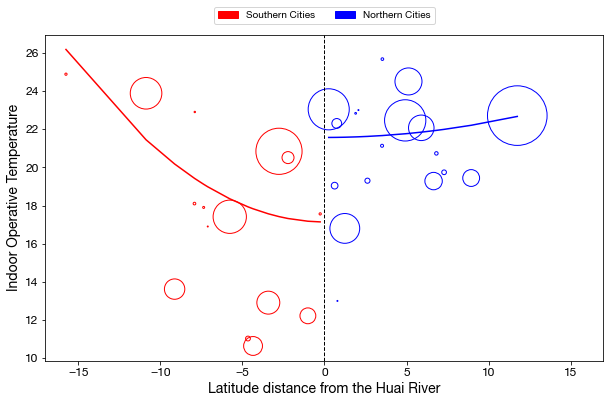

In [171]:
plt.figure(figsize=(10, 6))
# use the Helvetica Neue font
plt.rcParams['font.sans-serif'] = "Helvetica Neue"
# Split the data into two parts
df_below = df_rd[df_rd['distance'] < 0]
df_above = df_rd[df_rd['distance'] >= 0]
# Scatter plot for points below the threshold
plt.scatter(df_below['distance'], df_below['top'], s=df_below['records'], facecolors='none', edgecolors='red', label='South')
# Scatter plot for points above the threshold
plt.scatter(df_above['distance'], df_above['top'], s=df_above['records'], facecolors='none', edgecolors='blue', label='North')

# plot less than 0 distance for model.fittedvalues
plt.plot(df_rd['distance'][df_rd['distance'] < 0], model.fittedvalues[df_rd['distance'] < 0], color='r')
# plot larger than 0 distance for model.fittedvalues
plt.plot(df_rd['distance'][df_rd['distance'] >= 0], model.fittedvalues[df_rd['distance'] >= 0], color='b')
# plot a vertical dash line at the threshold
plt.axvline(x=0, color='k', linestyle="--", linewidth=1)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-17, 17)
# increase the font size of labels
plt.xlabel('Latitude distance from the Huai River', fontsize=14)
plt.ylabel('Indoor Operative Temperature', fontsize=14)
# show the legend below the x-label

import matplotlib.patches as mpatches
# Create custom legend handles
blue_patch = mpatches.Patch(color='blue', label='Northern Cities')
red_patch = mpatches.Patch(color='red', label='Southern Cities')
plt.legend(handles=[red_patch, blue_patch], loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)
plt.show()


summer time indoor top smoothness at the treshold

### Operative Temperature - Yes SD

In [349]:
model = smf.wls("top_std~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:     5.1169
Effect is:    -2.0135
pvalue is:  0.000


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.1169,0.352,14.553,0.000,4.394,5.840
distance,0.3354,0.058,5.816,0.000,0.217,0.454
threshold,-2.0135,0.429,-4.692,0.000,-2.896,-1.131
distance:threshold,-0.3854,0.066,-5.866,0.000,-0.520,-0.250


In [350]:
# try polynomial 
model = smf.wls("top_std ~ distance2*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:     4.3250
Effect is:    -1.3736
pvalue is:  0.000


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4.3250,0.245,17.674,0.000,3.822,4.828
distance2,-0.0257,0.004,-5.885,0.000,-0.035,-0.017
threshold,-1.3736,0.318,-4.316,0.000,-2.028,-0.719
distance2:threshold,0.0230,0.005,4.610,0.000,0.013,0.033


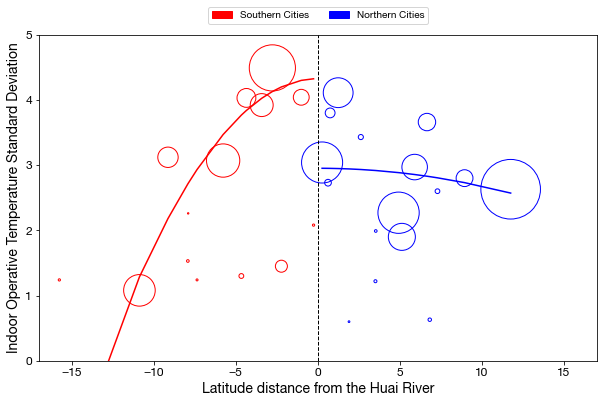

In [358]:
plt.figure(figsize=(10, 6))
# use the Helvetica Neue font
plt.rcParams['font.sans-serif'] = "Helvetica Neue"
# Split the data into two parts
df_below = df_rd[df_rd['distance'] < 0]
df_above = df_rd[df_rd['distance'] >= 0]
# Scatter plot for points below the threshold
plt.scatter(df_below['distance'], df_below['top_std'], s=df_below['records'], facecolors='none', edgecolors='red', label='South')
# Scatter plot for points above the threshold
plt.scatter(df_above['distance'], df_above['top_std'], s=df_above['records'], facecolors='none', edgecolors='blue', label='North')

# plot less than 0 distance for model.fittedvalues
plt.plot(df_rd['distance'][df_rd['distance'] < 0], model.fittedvalues[df_rd['distance'] < 0], color='r')
# plot larger than 0 distance for model.fittedvalues
plt.plot(df_rd['distance'][df_rd['distance'] >= 0], model.fittedvalues[df_rd['distance'] >= 0], color='b')
# plot a vertical dash line at the threshold
plt.axvline(x=0, color='k', linestyle="--", linewidth=1)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-17, 17)
plt.ylim(0, 5)
# increase the font size of labels
plt.xlabel('Latitude distance from the Huai River', fontsize=14)
plt.ylabel('Indoor Operative Temperature Standard Deviation', fontsize=14)
# show the legend below the x-label
blue_patch = mpatches.Patch(color='blue', label='Northern Cities')
red_patch = mpatches.Patch(color='red', label='Southern Cities')
plt.legend(handles=[red_patch, blue_patch], loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)
plt.show()


In [175]:
# plt.figure(figsize=(10, 6))
# SE = df_rd['top_std'] / np.sqrt(df_rd['records'])
# plt.errorbar(df_rd['distance'], df_rd['top'], yerr=SE, fmt='o', color='b', ecolor='gray', elinewidth=3, capsize=4)
# plt.xlabel('Distance')
# plt.ylabel('Indoor operative temperature)')
# plt.title('Mean indoor operative temperature with standard error as bar')

### Relative Humdity - Yes Mean, No SD

TBD: the absolute RH, humidity ratio

In [176]:
model = smf.wls("rh~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:    56.1940
Effect is:   -24.7888
pvalue is:  0.001


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,56.1940,5.242,10.720,0.000,45.419,66.969
distance,1.1168,0.860,1.299,0.205,-0.651,2.884
threshold,-24.7888,6.398,-3.874,0.001,-37.941,-11.637
distance:threshold,-0.9465,0.979,-0.966,0.343,-2.960,1.067


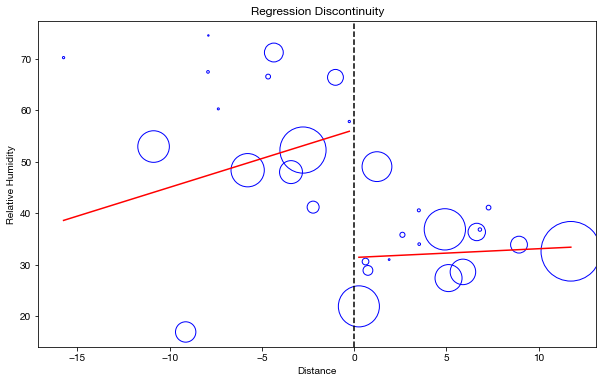

In [177]:
plt.figure(figsize=(10, 6))
plt.scatter(df_rd['distance'], df_rd['rh'], s=df_rd['records'], facecolors='none', edgecolors='b')
plt.plot(df_rd['distance'][df_rd['distance'] < 0], model.fittedvalues[df_rd['distance'] < 0], color='red')
plt.plot(df_rd['distance'][df_rd['distance'] >= 0], model.fittedvalues[df_rd['distance'] >= 0], color='red')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Distance')
plt.ylabel('Relative Humidity')
plt.title("Regression Discontinuity")
plt.show()

In [178]:
#### No causal effect on standard deviation of indoor relative humidity
model = smf.wls("rh_std~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:    14.1228
Effect is:    -0.2292
pvalue is:  0.902


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,14.1228,1.515,9.325,0.000,11.010,17.236
distance,0.3053,0.248,1.229,0.230,-0.205,0.816
threshold,-0.2292,1.849,-0.124,0.902,-4.029,3.571
distance:threshold,-0.6473,0.283,-2.287,0.031,-1.229,-0.066


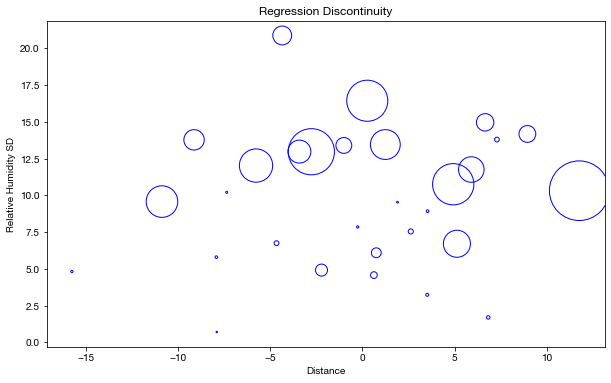

In [179]:
plt.figure(figsize=(10, 6))
plt.scatter(df_rd['distance'], df_rd['rh_std'], s=df_rd['records'], facecolors='none', edgecolors='b')
plt.xlabel('Distance')
plt.ylabel('Relative Humidity SD')
plt.title("Regression Discontinuity")
plt.show()

### Air Velocity - No

In [180]:
model = smf.wls("vel~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:    -0.0068
Effect is:     0.0304
pvalue is:  0.266


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.0068,0.022,-0.311,0.758,-0.052,0.038
distance,-0.0132,0.004,-3.666,0.001,-0.021,-0.006
threshold,0.0304,0.027,1.136,0.266,-0.025,0.085
distance:threshold,0.0143,0.004,3.494,0.002,0.006,0.023


### Metabolic Rate - No

In [181]:
model = smf.wls("met~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:     1.0996
Effect is:     0.0129
pvalue is:  0.716


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.0996,0.029,38.079,0.000,1.040,1.159
distance,0.0081,0.005,1.717,0.098,-0.002,0.018
threshold,0.0129,0.035,0.367,0.716,-0.060,0.085
distance:threshold,-0.0168,0.005,-3.105,0.005,-0.028,-0.006


### Clothing Insulation - No Mean

In [182]:
model = smf.wls("clo~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:     1.1943
Effect is:    -0.3049
pvalue is:  0.088


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.1943,0.141,8.475,0.000,0.905,1.484
distance,0.0355,0.023,1.535,0.137,-0.012,0.083
threshold,-0.3049,0.172,-1.773,0.088,-0.658,0.049
distance:threshold,-0.0316,0.026,-1.199,0.241,-0.086,0.023


In [183]:
# try polynomial 
model = smf.wls("clo ~ distance2*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:     1.1096
Effect is:    -0.2085
pvalue is:  0.113


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.1096,0.098,11.345,0.000,0.909,1.311
distance2,-0.0027,0.002,-1.544,0.135,-0.006,0.001
threshold,-0.2085,0.127,-1.639,0.113,-0.470,0.053
distance2:threshold,0.0029,0.002,1.463,0.155,-0.001,0.007


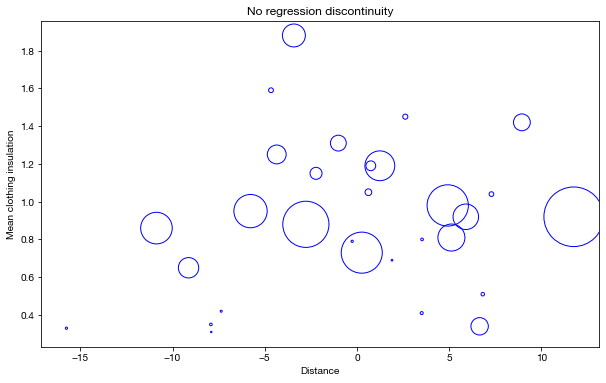

In [184]:
plt.figure(figsize=(10, 6))
plt.scatter(df_rd['distance'], df_rd['clo'], s=df_rd['records'], facecolors='none', edgecolors='b')
# plt.plot(df_rd['distance'][df_rd['distance'] < 0], model.fittedvalues[df_rd['distance'] < 0], color='red')
# plt.plot(df_rd['distance'][df_rd['distance'] >= 0], model.fittedvalues[df_rd['distance'] >= 0], color='red')
plt.xlabel('Distance')
plt.ylabel('Mean clothing insulation')
plt.title("No regression discontinuity")

plt.show()

### Clothing Insulation - Yes SD

In [185]:
model = smf.wls("clo_std~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:     0.5321
Effect is:    -0.1829
pvalue is:  0.001


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.5321,0.042,12.762,0.000,0.446,0.618
distance,0.0278,0.007,4.064,0.000,0.014,0.042
threshold,-0.1829,0.051,-3.594,0.001,-0.288,-0.078
distance:threshold,-0.0300,0.008,-3.853,0.001,-0.046,-0.014


In [186]:
# try polynomial 
model = smf.wls("clo_std ~ distance2*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:     0.4681
Effect is:    -0.1223
pvalue is:  0.003


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4681,0.028,16.571,0.000,0.410,0.526
distance2,-0.0022,0.001,-4.310,0.000,-0.003,-0.001
threshold,-0.1223,0.037,-3.330,0.003,-0.198,-0.047
distance2:threshold,0.0020,0.001,3.474,0.002,0.001,0.003


Text(0, 0.5, 'Standard deviation of clothing insulation')

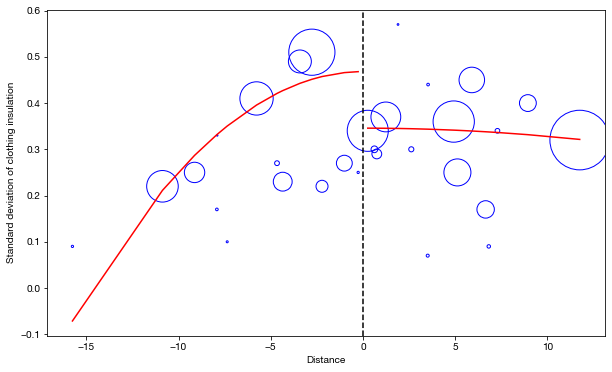

In [187]:
plt.figure(figsize=(10, 6))
plt.scatter(df_rd['distance'], df_rd['clo_std'], s=df_rd['records'], facecolors='none', edgecolors='b')
plt.plot(df_rd['distance'][df_rd['distance'] < 0], model.fittedvalues[df_rd['distance'] < 0], color='red')
plt.plot(df_rd['distance'][df_rd['distance'] >= 0], model.fittedvalues[df_rd['distance'] >= 0], color='red')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Distance')
plt.ylabel('Standard deviation of clothing insulation')
# plt.title("No regression discontinuity")

In [188]:
model = smf.wls("clo~top", df_rd, weights=df_rd["records"]).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.7656,0.235,7.528,0.000,1.285,2.246
top,-0.0394,0.011,-3.525,0.001,-0.062,-0.016


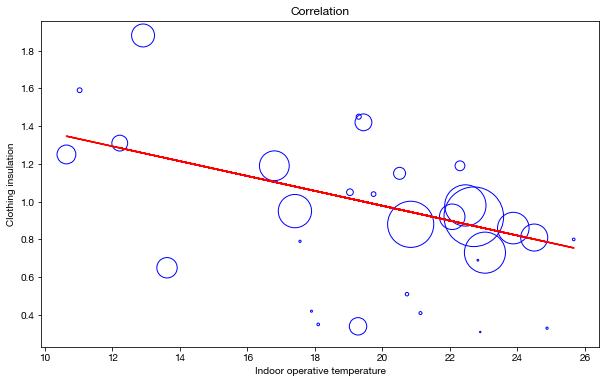

In [189]:
# scatter plot clo against top
plt.figure(figsize=(10, 6))
plt.scatter(df_rd['top'], df_rd['clo'], s=df_rd['records'], facecolors='none', edgecolors='b')
# plot the fitted values
plt.plot(df_rd['top'], model.fittedvalues, color='red')
plt.title("Correlation")
plt.xlabel('Indoor operative temperature')
plt.ylabel('Clothing insulation')
plt.show()

In [190]:
model = smf.wls("clo_std~top_std", df_rd, weights=df_rd["records"]).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1595,0.043,3.693,0.001,0.071,0.248
top_std,0.0649,0.014,4.723,0.000,0.037,0.093


Text(0.5, 0, 'Indoor operative temperature standard deviation')

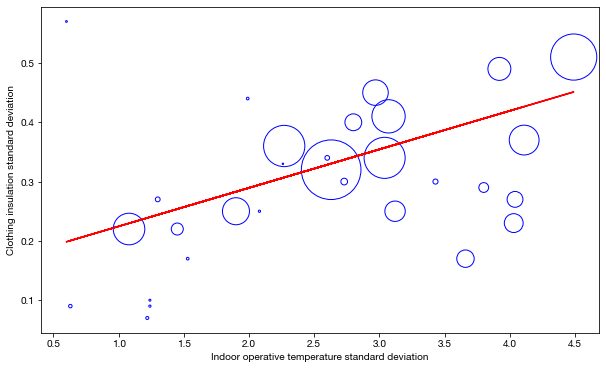

In [191]:
# scatter plot clo_std against top_std
plt.figure(figsize=(10, 6))
plt.scatter(df_rd['top_std'], df_rd['clo_std'], s=df_rd['records'], facecolors='none', edgecolors='b')
# plot the fitted values
plt.plot(df_rd['top_std'], model.fittedvalues, color='red')
plt.ylabel('Clothing insulation standard deviation')
plt.xlabel('Indoor operative temperature standard deviation')


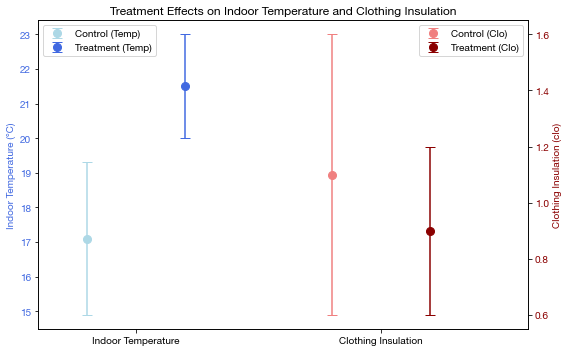

In [403]:
import matplotlib.pyplot as plt
import numpy as np

# Data for indoor temperature
temp_control = 17.1
temp_treatment = 21.5
temp_control_err = 2.2
temp_treatment_err = 1.5

# Data for clothing insulation
clo_control = 1.1
clo_treatment = 0.9
clo_control_err = 0.5
clo_treatment_err = 0.3

# Set positions with a smaller distance and extra padding on the left
variables = ['Indoor Temperature', 'Clothing Insulation']
x = np.array([0.2, 0.7])  # Closer spacing, shifted slightly to the right

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot indoor temperature data points with error bars (left y-axis)
temp_control_point = ax1.errorbar(x[0] - 0.1, temp_control, yerr=temp_control_err, fmt='o', color='lightblue', 
                                  label='Control (Temp)', capsize=5, markersize=8)
temp_treatment_point = ax1.errorbar(x[0] + 0.1, temp_treatment, yerr=temp_treatment_err, fmt='o', color='royalblue', 
                                    label='Treatment (Temp)', capsize=5, markersize=8)
ax1.set_ylabel('Indoor Temperature (°C)', color='royalblue')
ax1.tick_params(axis='y', labelcolor='royalblue')

# Create secondary axis for clothing insulation data points
ax2 = ax1.twinx()
clo_control_point = ax2.errorbar(x[1] - 0.1, clo_control, yerr=clo_control_err, fmt='o', color='lightcoral', 
                                 label='Control (Clo)', capsize=5, markersize=8)
clo_treatment_point = ax2.errorbar(x[1] + 0.1, clo_treatment, yerr=clo_treatment_err, fmt='o', color='darkred', 
                                   label='Treatment (Clo)', capsize=5, markersize=8)
ax2.set_ylabel('Clothing Insulation (clo)', color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')

# Set custom x-axis limits to add padding before the first data point
ax1.set_xlim(0, 1)

# Add labels, legends, and title
ax1.set_xticks(x)
ax1.set_xticklabels(variables)
ax1.set_title('Treatment Effects on Indoor Temperature and Clothing Insulation')

# Separate legends for each axis
ax1.legend(loc='upper left')  # Indoor temperature legend on upper left
ax2.legend(loc='upper right')  # Clothing insulation legend on upper right

# Adjust layout and show plot
fig.tight_layout()
plt.show()


### Conclusions


The policy affects mean indoor top and the variation of top </br>
The policy affects mean indoor rh </br>
The policy doesn't affect mean clo </br>
But the policy affects the variation of clo </br>

Assuming that the policy affects clothing insulation only through indoor thermal environment, represented by top and rh </br>
policy -> top & rh -> clo </br>
Then, increasing mean top or decreasing rh doesn't affect mean clo. </br>
However, reducing variation of top affect variation of clo </br>
2C delta top -> 0.2 delta clo

### Thermal Sensation Vote - Yes

In [340]:
model = smf.wls("tsv~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:    -0.4039
Effect is:     0.6373
pvalue is:  0.028


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.4039,0.224,-1.803,0.083,-0.864,0.057
distance,-0.0034,0.037,-0.092,0.927,-0.079,0.072
threshold,0.6373,0.273,2.330,0.028,0.075,1.199
distance:threshold,0.0036,0.042,0.086,0.932,-0.082,0.090


In [380]:
# try polynomial 
model = smf.wls("tsv ~ distance2*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:    -0.4313
Effect is:     0.6439
pvalue is:  0.004


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.4313,0.155,-2.788,0.010,-0.749,-0.113
distance2,0.0012,0.003,0.439,0.665,-0.004,0.007
threshold,0.6439,0.201,3.199,0.004,0.230,1.058
distance2:threshold,-0.0008,0.003,-0.269,0.790,-0.007,0.006


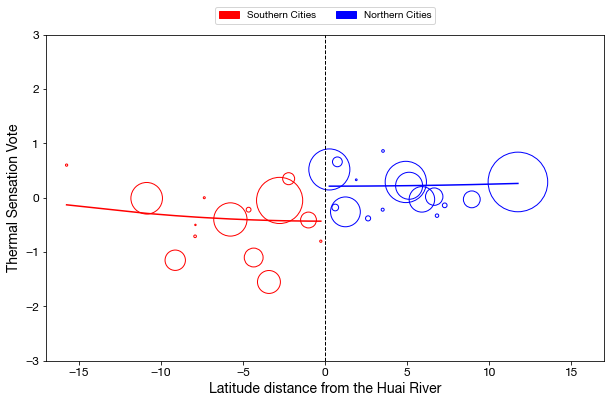

In [381]:
plt.figure(figsize=(10, 6))
# use the Helvetica Neue font
plt.rcParams['font.sans-serif'] = "Helvetica Neue"
# Split the data into two parts
df_below = df_rd[df_rd['distance'] < 0]
df_above = df_rd[df_rd['distance'] >= 0]
# Scatter plot for points below the threshold
plt.scatter(df_below['distance'], df_below['tsv'], s=df_below['records'], facecolors='none', edgecolors='red', label='South')
# Scatter plot for points above the threshold
plt.scatter(df_above['distance'], df_above['tsv'], s=df_above['records'], facecolors='none', edgecolors='blue', label='North')

# plot less than 0 distance for model.fittedvalues
plt.plot(df_rd['distance'][df_rd['distance'] < 0], model.fittedvalues[df_rd['distance'] < 0], color='r')
# plot larger than 0 distance for model.fittedvalues
plt.plot(df_rd['distance'][df_rd['distance'] >= 0], model.fittedvalues[df_rd['distance'] >= 0], color='b')
# plot a vertical dash line at the threshold
plt.axvline(x=0, color='k', linestyle="--", linewidth=1)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-17, 17)
plt.ylim(-3, 3)
# increase the font size of labels
plt.xlabel('Latitude distance from the Huai River', fontsize=14)
plt.ylabel('Thermal Sensation Vote', fontsize=14)
# show the legend below the x-label

import matplotlib.patches as mpatches
# Create custom legend handles
blue_patch = mpatches.Patch(color='blue', label='Northern Cities')
red_patch = mpatches.Patch(color='red', label='Southern Cities')
plt.legend(handles=[red_patch, blue_patch], loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)
plt.show()


Assuming that the policy affects thermal sensations only through indoor thermal environment, represented by top and rh </br>
Which means there is no psychological effect </br>
Then, then increasing mean indoor top from 16.4 to 21.3 (5 delta) would increase thermal sensation from -0.4 to 0.2 (0.6 delta) </br>
It's hard to compare with PMV model due to the unknown clo value. Two groups have the same clo, but which values to use is unceratin. At different values, PMV have different output delta TSV. 

correlation model

In [194]:
model = smf.wls("tsv~top", df_rd, weights=df_rd["records"]).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-2.5081,0.259,-9.669,0.000,-3.039,-1.977
top,0.1212,0.012,9.811,0.000,0.096,0.146


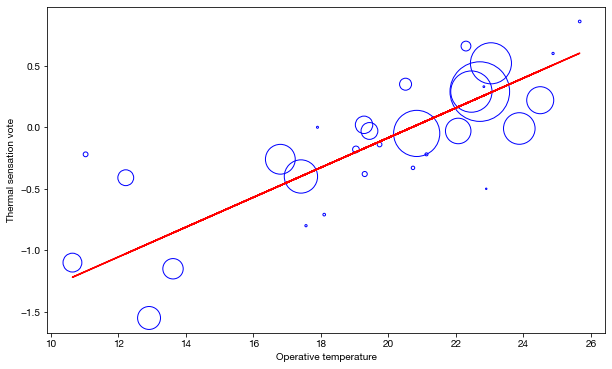

In [195]:
# scatter plot tsv against operative temperature
plt.figure(figsize=(10, 6))
plt.scatter(df_rd['top'], df_rd['tsv'], s=df_rd['records'], facecolors='none', edgecolors='b')
# plot the fitted values
plt.plot(df_rd['top'], model.fittedvalues, color='red')
plt.xlabel('Operative temperature')
plt.ylabel('Thermal sensation vote')
plt.show()

In [196]:
# calculate the predicted thermal sensation vote at operative temeprature at 16.4 and 21.3
tsv_16 = model.predict(pd.DataFrame({'top': [16.4]}))
tsv_21 = model.predict(pd.DataFrame({'top': [21.3]}))
print("Predicted thermal sensation vote at 16.4 degree is:", tsv_16)
print("Predicted thermal sensation vote at 21.3 degree is:", tsv_21)

Predicted thermal sensation vote at 16.4 degree is: 0   -0.521092
dtype: float64
Predicted thermal sensation vote at 21.3 degree is: 0    0.072574
dtype: float64


In [197]:
# ASHRAE db2
url_meta = "https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_metadata.csv"
df_meta = pd.read_csv(url_meta)

# Read database from Github
url_measurements = "https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_measurements_v2.1.0.csv.gz"
df_measurements = pd.read_csv(url_measurements)

# Merge building metadata and measurement data
df_rawdata = df_measurements.merge(df_meta[['building_id', 'building_type', 'cooling_type', 'records', 'climate']], on='building_id', how='left')

print('Total buildings:', len(df_rawdata.building_id.unique()))
print('Total records:', len(df_rawdata))

Total buildings: 809
Total records: 109033


/var/folders/v0/03v41tbn7072cjr0b3ddfgjw0000gn/T/ipykernel_3831/2919751080.py:7: DtypeWarning: Columns (5,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_measurements = pd.read_csv(url_measurements)


In [198]:
# group by building id and calculate the mean of top and thermal_sensation, and records
df_grouped = df_rawdata.groupby('building_id').agg({'top': 'mean', 'thermal_sensation': 'mean', 'records': 'mean'}).reset_index()


In [199]:
df_grouped.head()

,building_id,top,thermal_sensation,records
0,1,23.246958,0.627219,170.0
1,2,22.283912,-0.072289,83.0
2,3,23.178237,0.252941,85.0
3,4,23.992550,0.103704,137.0
4,5,22.095310,-0.063281,128.0


In [200]:
model = smf.wls("thermal_sensation~top", df_grouped, weights=df_grouped["records"]).fit()

In [201]:
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-2.5576,0.148,-17.270,0.000,-2.848,-2.267
top,0.1091,0.006,18.304,0.000,0.097,0.121


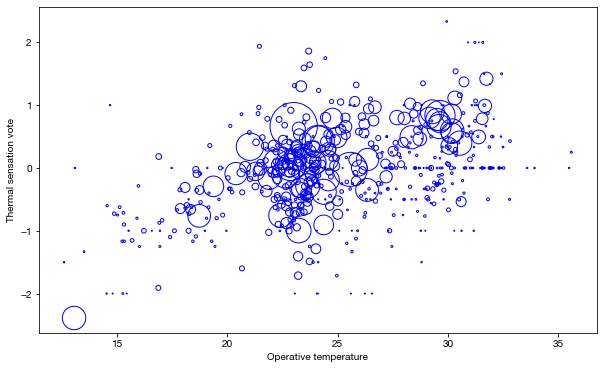

In [202]:
# plot top against tsv
plt.figure(figsize=(10, 6))
plt.scatter(df_grouped['top'], df_grouped['thermal_sensation'], s=df_grouped['records'], facecolors='none', edgecolors='b')
plt.xlabel('Operative temperature')
plt.ylabel('Thermal sensation vote')
plt.show()


the correlational effect is very similar to causal effect!

### Comfort Vote - No
heat realted outcome data, heat related hospital visiting

In [382]:
model = smf.wls("tcv~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:     1.6940
Effect is:    -0.2112
pvalue is:  0.468


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.6940,0.240,7.046,0.000,1.198,2.190
distance,-0.0035,0.038,-0.093,0.927,-0.082,0.075
threshold,-0.2112,0.286,-0.738,0.468,-0.802,0.379
distance:threshold,0.0103,0.043,0.240,0.812,-0.078,0.099


In [383]:
# try polynomial 
model = smf.wls("tcv ~ distance2*threshold", df_rd, weights=df_rd["records"]).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.7729,0.164,10.816,0.000,1.435,2.111
distance2,-0.0015,0.003,-0.535,0.598,-0.007,0.004
threshold,-0.2992,0.207,-1.444,0.162,-0.727,0.128
distance2:threshold,0.0023,0.003,0.743,0.465,-0.004,0.009


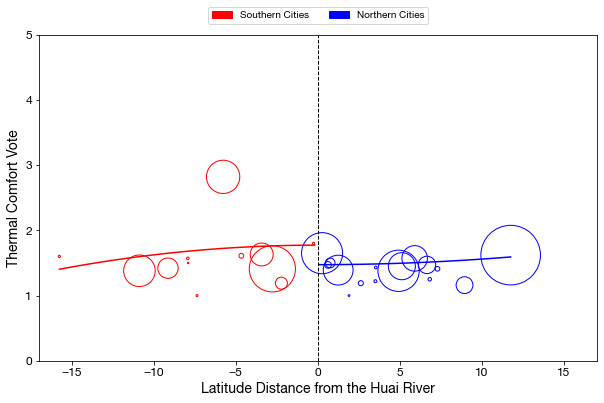

In [384]:
# Define a range of distance values
distance_values = np.linspace(df_rd['distance'].min(), df_rd['distance'].max(), 100)
distance2_values = distance_values ** 2

# Prepare a DataFrame for predictions
predict_df = pd.DataFrame({
    'distance': distance_values,
    'distance2': distance2_values,
    'threshold': (distance_values >= 0).astype(int)  # 1 if distance >= 0, else 0
})

# Generate predictions using the model
predict_df['predictions'] = model.predict(predict_df)

# Plot the data and the model's fitted values
plt.figure(figsize=(10, 6))

# Scatter plot for points below and above the threshold
df_below = df_rd[df_rd['distance'] < 0]
df_above = df_rd[df_rd['distance'] >= 0]
plt.scatter(df_below['distance'], df_below['tcv'], s=df_below['records'], facecolors='none', edgecolors='red', label='South')
plt.scatter(df_above['distance'], df_above['tcv'], s=df_above['records'], facecolors='none', edgecolors='blue', label='North')

# Plot the fitted values from the prediction DataFrame
plt.plot(predict_df['distance'][predict_df['threshold'] == 0], predict_df['predictions'][predict_df['threshold'] == 0], color='red')
plt.plot(predict_df['distance'][predict_df['threshold'] == 1], predict_df['predictions'][predict_df['threshold'] == 1], color='blue')

# Add a vertical dashed line at the threshold
plt.axvline(x=0, color='k', linestyle="--", linewidth=1)

# Label and style the plot
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-17, 17)
plt.ylim(0, 5)
plt.xlabel('Latitude Distance from the Huai River', fontsize=14)
plt.ylabel('Thermal Comfort Vote', fontsize=14)

# Add custom legend
blue_patch = mpatches.Patch(color='blue', label='Northern Cities')
red_patch = mpatches.Patch(color='red', label='Southern Cities')
plt.legend(handles=[red_patch, blue_patch], loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.show()


### Satisfaction Rate - No

In [330]:
model = smf.wls("tsr~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:     0.8135
Effect is:     0.0392
pvalue is:  0.610


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.8135,0.062,13.100,0.000,0.686,0.941
distance,-0.0028,0.010,-0.272,0.787,-0.024,0.018
threshold,0.0392,0.076,0.517,0.610,-0.117,0.195
distance:threshold,0.0017,0.012,0.149,0.883,-0.022,0.026


In [375]:
# try polynomial 
model = smf.wls("tsr ~ distance2*threshold", df_rd, weights=df_rd["records"]).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.8171,0.043,19.077,0.000,0.729,0.905
distance2,0.0003,0.001,0.384,0.704,-0.001,0.002
threshold,0.0424,0.056,0.762,0.453,-0.072,0.157
distance2:threshold,-0.0005,0.001,-0.590,0.560,-0.002,0.001


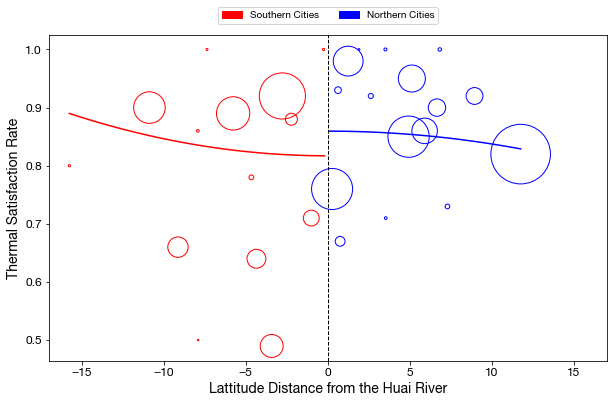

In [378]:


# Define a range of distance values
distance_values = np.linspace(df_rd['distance'].min(), df_rd['distance'].max(), 100)
distance2_values = distance_values ** 2

# Prepare a DataFrame for predictions
predict_df = pd.DataFrame({
    'distance': distance_values,
    'distance2': distance2_values,
    'threshold': (distance_values >= 0).astype(int)  # 1 if distance >= 0, else 0
})

# Generate predictions using the model
predict_df['predictions'] = model.predict(predict_df)

# Plot the data and the model's fitted values
plt.figure(figsize=(10, 6))

# Scatter plot for points below and above the threshold
df_below = df_rd[df_rd['distance'] < 0]
df_above = df_rd[df_rd['distance'] >= 0]
plt.scatter(df_below['distance'], df_below['tsr'], s=df_below['records'], facecolors='none', edgecolors='red', label='South')
plt.scatter(df_above['distance'], df_above['tsr'], s=df_above['records'], facecolors='none', edgecolors='blue', label='North')

# Plot the fitted values from the prediction DataFrame
plt.plot(predict_df['distance'][predict_df['threshold'] == 0], predict_df['predictions'][predict_df['threshold'] == 0], color='red')
plt.plot(predict_df['distance'][predict_df['threshold'] == 1], predict_df['predictions'][predict_df['threshold'] == 1], color='blue')

# Add a vertical dashed line at the threshold
plt.axvline(x=0, color='k', linestyle="--", linewidth=1)

# Label and style the plot
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-17, 17)
# plt.ylim(0, 1)
plt.xlabel('Lattitude Distance from the Huai River', fontsize=14)
plt.ylabel('Thermal Satisfaction Rate', fontsize=14)

# Add custom legend
blue_patch = mpatches.Patch(color='blue', label='Northern Cities')
red_patch = mpatches.Patch(color='red', label='Southern Cities')
plt.legend(handles=[red_patch, blue_patch], loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.show()


In [312]:
model = smf.wls("tsr~top", df_rd, weights=df_rd["records"]).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.5832,0.107,5.476,0.000,0.365,0.801
top,0.0124,0.005,2.436,0.021,0.002,0.023


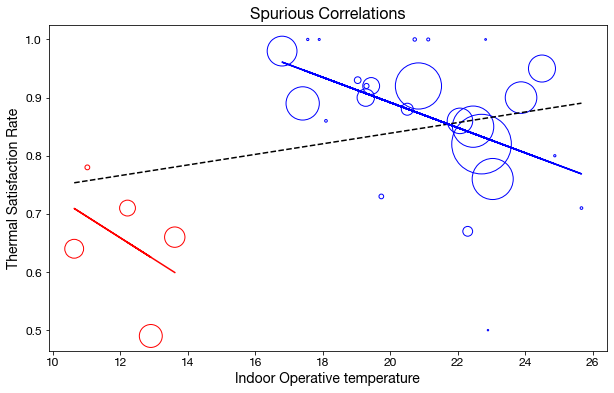

In [361]:
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import pandas as pd

# Fit the model for the whole dataset
model_whole = smf.ols("tsr ~ top", data=df_rd).fit()

# Split the data into two parts based on the threshold of 16 degrees
threshold = 16
df_below = df_rd[df_rd['top'] < threshold]
df_above = df_rd[df_rd['top'] >= threshold]

# Fit the models for each group
model_below = smf.ols("tsr ~ top", data=df_below).fit()
model_above = smf.ols("tsr ~ top", data=df_above).fit()

plt.rcParams['font.sans-serif'] = "Helvetica Neue"
# Scatter plot
plt.figure(figsize=(10, 6))

# Scatter plot for points below the threshold
plt.scatter(df_below['top'], df_below['tsr'], s=df_below['records'], facecolors='none', edgecolors='red', label='Below 16°C')

# Scatter plot for points above the threshold
plt.scatter(df_above['top'], df_above['tsr'], s=df_above['records'], facecolors='none', edgecolors='blue', label='Above 16°C')

# Sort the data for plotting the regression line
df_rd_sorted = df_rd.sort_values(by='top')

# Plot the fitted values for the whole dataset as a dashed black line
plt.plot(df_rd_sorted['top'], model_whole.predict(df_rd_sorted), color='black', linestyle='--', label='Whole Data')

# Plot the fitted values for below 16 degrees
plt.plot(df_below['top'], model_below.fittedvalues, color='red', label='Below 16°C')

# Plot the fitted values for above 16 degrees
plt.plot(df_above['top'], model_above.fittedvalues, color='blue', label='Above 16°C')

# Add labels and title
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Indoor Operative temperature', fontsize=14)
plt.ylabel('Thermal Satisfaction Rate', fontsize=14)
plt.title('Spurious Correlations', fontsize=16)
# plt.legend()
plt.show()

In [211]:
# calculate the predicted thermal sensation vote at operative temeprature at 16.4 and 21.3
tsr_16 = model.predict(pd.DataFrame({'top': [16.4]}))
tsr_21 = model.predict(pd.DataFrame({'top': [21.3]}))
print("Predicted thermal satisfaction rate at 16.4 degree is:", tsr_16)
print("Predicted thermal satisfaction rate at 21.3 degree is:", tsr_21)

Predicted thermal satisfaction rate at 16.4 degree is: 0    0.785842
dtype: float64
Predicted thermal satisfaction rate at 21.3 degree is: 0    0.846382
dtype: float64


### Acceptablity Vote - No

In [212]:
model = smf.wls("tav~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:     0.2778
Effect is:    -0.0776
pvalue is:  0.489


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2778,0.089,3.109,0.005,0.093,0.463
distance,-0.0219,0.014,-1.548,0.135,-0.051,0.007
threshold,-0.0776,0.110,-0.703,0.489,-0.306,0.151
distance:threshold,0.0680,0.016,4.203,0.000,0.035,0.101


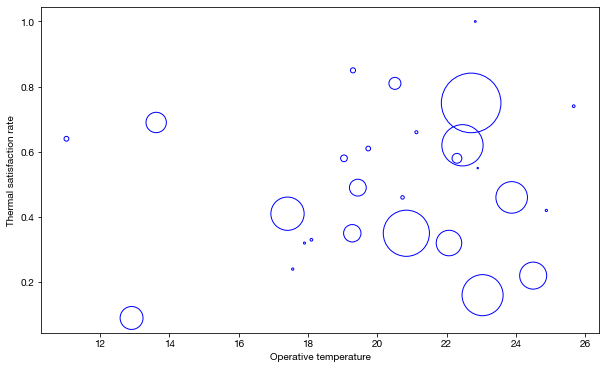

In [213]:
# scatter plot tsv against operative temperature
plt.figure(figsize=(10, 6))
plt.scatter(df_rd['top'], df_rd['tav'], s=df_rd['records'], facecolors='none', edgecolors='b')
# plot the fitted values
plt.xlabel('Operative temperature')
plt.ylabel('Thermal satisfaction rate')
plt.show()

## Effect of P on Neutral Temperature (tricky)


In [214]:
# needs one more non-NaN neutral temperature/comfort zone calcualted by regression approach a and b
# neutral temperature calcualted by Griffth method, and using measured globe temperature
model = smf.wls("tn_op~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Causal effect is:", model.summary().tables[1][3][1])
print("p-value is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Causal effect is:     3.3097
p-value is:  0.046


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,17.4589,1.291,13.522,0.000,14.805,20.113
distance,-0.3840,0.212,-1.813,0.081,-0.819,0.051
threshold,3.3097,1.576,2.100,0.046,0.070,6.549
distance:threshold,0.4912,0.241,2.036,0.052,-0.005,0.987


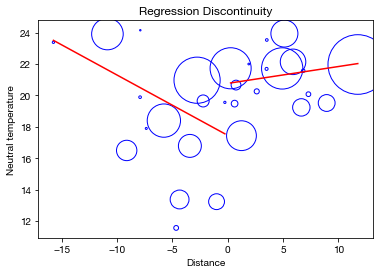

In [215]:
# scatter plot tn_op vs distance
plt.scatter(df_rd['distance'], df_rd['tn_op'], s=df_rd['records'], facecolors='none', edgecolors='b')
plt.plot(df_rd['distance'][df_rd['distance'] < 0], model.fittedvalues[df_rd['distance'] < 0], color='red')
plt.plot(df_rd['distance'][df_rd['distance'] >= 0], model.fittedvalues[df_rd['distance'] >= 0], color='red')
plt.xlabel('Distance')
plt.ylabel('Neutral temperature')
plt.title("Regression Discontinuity")
plt.show()

Assuming that the policy can only affect the neutral temperature through indoor thermal enviornment, represented by the tg. Then the causal effect of indoor globe temperature on neutral temperature is 4.6279/5.2973 = 0.87 (95% CI:0.64, 0.92)

## Effect of X on Comfort Vote
The assumption is that the district heating policy affects Y only through indoor thermal environment, represented by  </br>

P -> X -> Y

## Use outdoor design temperaure

In [241]:
# create a new df and order the data by t_out_min
df_rd_out = df_rd.sort_values('t_out_min')
# order df_rd_out by t_out_min
df_rd_out = df_rd_out.sort_values('t_out_min')
df_rd_out

,city,records,top,top_std,rh,rh_std,twb,vel,met,clo,...,t_out,t_out_min,latitude,tsr,tn_op,p_dh,p_nv,distance,threshold,distance2
32,HeilongjiangHarbin,3552,22.71,2.63,32.61,10.32,13.47,0.04,1.01,0.92,...,-7.17,-17.4,45.75,0.82,21.97,1.00,0.00,11.75,1,138.0625
30,LiaoningBenxi,22,19.74,2.60,41.09,13.80,12.15,0.00,0.96,1.04,...,-0.91,-10.9,41.29,0.73,20.08,1.00,0.00,7.29,1,53.1441
29,Hohhot,12,20.73,0.63,36.83,1.70,12.44,0.00,0.96,0.51,...,NaN,-10.7,40.82,1.00,21.57,1.00,0.00,6.82,1,46.5124
28,Baotou,303,19.28,3.66,36.36,14.97,11.44,0.05,1.07,0.34,...,-8.60,-10.4,40.65,0.90,19.24,1.00,0.00,6.65,1,44.2225
20,ShandongXintai,3,22.83,0.60,31.00,9.54,13.03,0.00,0.90,0.69,...,NaN,-7.4,35.90,1.00,22.00,1.00,0.00,1.90,1,3.6100
31,Turpan,283,19.44,2.80,33.90,14.18,9.79,0.02,1.19,1.42,...,-7.52,-6.5,42.94,0.92,19.52,0.00,0.19,8.94,1,79.9236
23,ShanxiLvliangfenyang,9,21.13,1.22,40.56,3.24,13.30,0.00,0.97,0.41,...,NaN,-4.8,37.51,1.00,21.69,1.00,0.00,3.51,1,12.3201
25,LiaoningDalian,1703,22.46,2.27,36.87,10.76,13.71,0.00,0.99,0.98,...,0.83,-3.4,38.92,0.85,21.72,0.80,0.00,4.92,1,24.2064
26,Tianjin,730,24.50,1.90,27.41,6.71,13.70,0.02,1.16,0.81,...,1.80,-3.3,39.12,0.95,23.94,0.98,0.00,5.12,1,26.2144
27,Beijing,651,22.07,2.97,28.61,11.76,12.57,0.07,1.06,0.92,...,5.81,-2.8,39.90,0.86,22.14,0.76,0.00,5.90,1,34.8100


In [248]:
# create a new dummy variable based on the distance
df_rd_out = df_city.assign(threshold_out=(df_city["t_out_min"] < 0).astype(int))

In [249]:
model = smf.wls("top ~ t_out_min*threshold_out", df_rd_out, weights=df_rd_out["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:    17.9938
Effect is:     2.7788
pvalue is:  0.181


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,17.9938,1.422,12.654,0.000,15.085,20.902
t_out_min,0.3028,0.221,1.370,0.181,-0.149,0.755
threshold_out,2.7788,2.029,1.370,0.181,-1.370,6.928
t_out_min:threshold_out,-0.4175,0.250,-1.667,0.106,-0.930,0.095


In [250]:
df_rd_out['t_out_min2'] = df_rd_out['t_out_min'] ** 2
# try polynomial 
model = smf.wls("top ~ t_out_min2*threshold_out", df_rd_out, weights=df_rd_out["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:    18.7512
Effect is:     2.4579
pvalue is:  0.122


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,18.7512,0.970,19.340,0.000,16.768,20.734
t_out_min2,0.0208,0.014,1.525,0.138,-0.007,0.049
threshold_out,2.4579,1.541,1.595,0.122,-0.695,5.610
t_out_min2:threshold_out,-0.0160,0.015,-1.083,0.288,-0.046,0.014


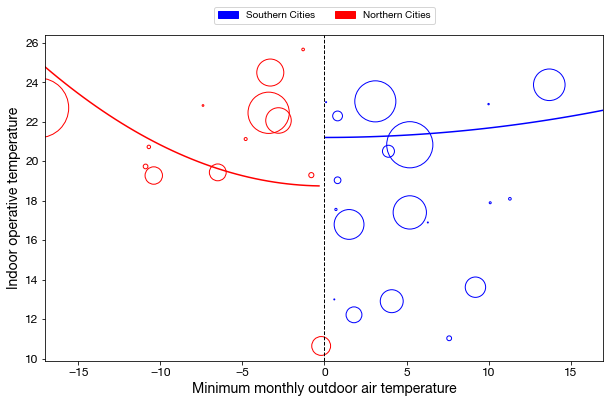

In [251]:
# Define a range of t_out_min values
t_out_min_values = np.linspace(df_rd_out['t_out_min'].min(), df_rd_out['t_out_min'].max(), 100)
t_out_min2_values = t_out_min_values ** 2

# Prepare a DataFrame for predictions
predict_df = pd.DataFrame({
    't_out_min': t_out_min_values,
    't_out_min2': t_out_min2_values,
    'threshold_out': (t_out_min_values >= 0).astype(int)  # 1 if t_out_min >= 0, else 0
})

# Generate predictions using the model
predict_df['predictions'] = model.predict(predict_df)

# Plot the data and the model's fitted values
plt.figure(figsize=(10, 6))

# Scatter plot for points below and above the threshold_out
df_below = df_rd_out[df_rd_out['t_out_min'] < 0]
df_above = df_rd_out[df_rd_out['t_out_min'] >= 0]
plt.scatter(df_below['t_out_min'], df_below['top'], s=df_below['records'], facecolors='none', edgecolors='red', label='South')
plt.scatter(df_above['t_out_min'], df_above['top'], s=df_above['records'], facecolors='none', edgecolors='blue', label='North')

# Plot the fitted values from the prediction DataFrame
plt.plot(predict_df['t_out_min'][predict_df['threshold_out'] == 0], predict_df['predictions'][predict_df['threshold_out'] == 0], color='red')
plt.plot(predict_df['t_out_min'][predict_df['threshold_out'] == 1], predict_df['predictions'][predict_df['threshold_out'] == 1], color='blue')

# Add a vertical dashed line at the threshold_out
plt.axvline(x=0, color='k', linestyle="--", linewidth=1)

# Label and style the plot
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-17, 17)
plt.xlabel('Minimum monthly outdoor air temperature', fontsize=14)
plt.ylabel('Indoor operative temperature', fontsize=14)

# Add custom legend
blue_patch = mpatches.Patch(color='red', label='Northern Cities')
red_patch = mpatches.Patch(color='b', label='Southern Cities')
plt.legend(handles=[red_patch, blue_patch], loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.show()


### Comfort vote - No

In [221]:
# try polynomial 
model = smf.wls("tcv ~ t_out_min2*threshold_out", df_rd_out, weights=df_rd_out["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:     1.4030
Effect is:     0.3248
pvalue is:  0.086


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.4030,0.143,9.777,0.000,1.109,1.697
t_out_min2,0.0007,0.001,1.046,0.305,-0.001,0.002
threshold_out,0.3248,0.182,1.780,0.086,-0.050,0.699
t_out_min2:threshold_out,-0.0023,0.002,-1.342,0.191,-0.006,0.001


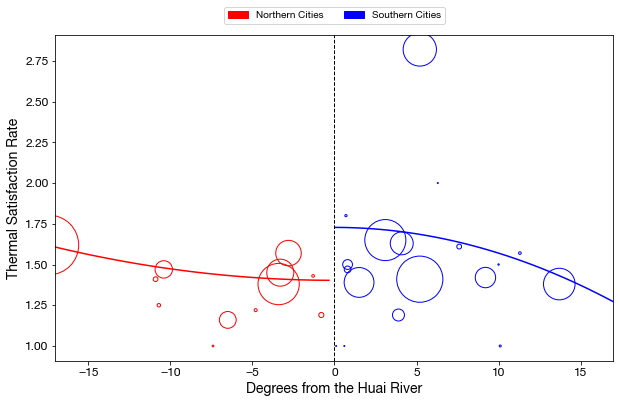

In [222]:
# Define a range of t_out_min values
t_out_min_values = np.linspace(df_rd_out['t_out_min'].min(), df_rd_out['t_out_min'].max(), 100)
t_out_min2_values = t_out_min_values ** 2

# Prepare a DataFrame for predictions
predict_df = pd.DataFrame({
    't_out_min': t_out_min_values,
    't_out_min2': t_out_min2_values,
    'threshold_out': (t_out_min_values >= 0).astype(int)  # 1 if t_out_min >= 0, else 0
})

# Generate predictions using the model
predict_df['predictions'] = model.predict(predict_df)

# Plot the data and the model's fitted values
plt.figure(figsize=(10, 6))

# Scatter plot for points below and above the threshold_out
df_below = df_rd_out[df_rd_out['t_out_min'] < 0]
df_above = df_rd_out[df_rd_out['t_out_min'] >= 0]
plt.scatter(df_below['t_out_min'], df_below['tcv'], s=df_below['records'], facecolors='none', edgecolors='red', label='South')
plt.scatter(df_above['t_out_min'], df_above['tcv'], s=df_above['records'], facecolors='none', edgecolors='blue', label='North')

# Plot the fitted values from the prediction DataFrame
plt.plot(predict_df['t_out_min'][predict_df['threshold_out'] == 0], predict_df['predictions'][predict_df['threshold_out'] == 0], color='red')
plt.plot(predict_df['t_out_min'][predict_df['threshold_out'] == 1], predict_df['predictions'][predict_df['threshold_out'] == 1], color='blue')

# Add a vertical dashed line at the threshold_out
plt.axvline(x=0, color='k', linestyle="--", linewidth=1)

# Label and style the plot
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-17, 17)
plt.xlabel('Degrees from the Huai River', fontsize=14)
plt.ylabel('Thermal Satisfaction Rate', fontsize=14)

# Add custom legend
blue_patch = mpatches.Patch(color='blue', label='Southern Cities')
red_patch = mpatches.Patch(color='red', label='Northern Cities')
plt.legend(handles=[red_patch, blue_patch], loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.show()


### Senstaion vote - No

In [228]:
model = smf.wls("tsv ~ t_out_min2*threshold_out", df_rd_out, weights=df_rd_out["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:     0.0401
Effect is:    -0.1682
pvalue is:  0.450


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0401,0.171,0.234,0.816,-0.309,0.389
t_out_min2,0.0008,0.001,1.002,0.325,-0.001,0.003
threshold_out,-0.1682,0.220,-0.765,0.450,-0.618,0.281
t_out_min2:threshold_out,-0.0013,0.002,-0.593,0.558,-0.006,0.003


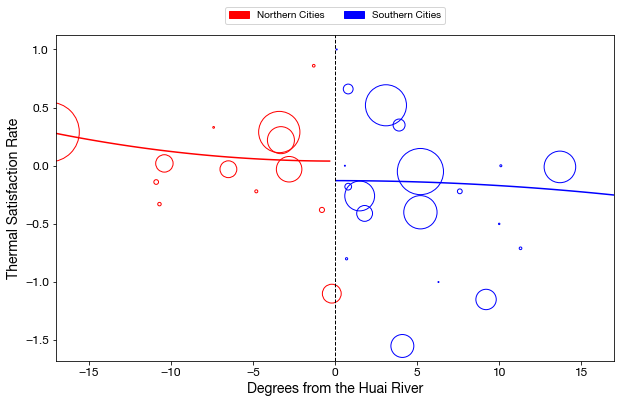

In [229]:
# Define a range of t_out_min values
t_out_min_values = np.linspace(df_rd_out['t_out_min'].min(), df_rd_out['t_out_min'].max(), 100)
t_out_min2_values = t_out_min_values ** 2

# Prepare a DataFrame for predictions
predict_df = pd.DataFrame({
    't_out_min': t_out_min_values,
    't_out_min2': t_out_min2_values,
    'threshold_out': (t_out_min_values >= 0).astype(int)  # 1 if t_out_min >= 0, else 0
})

# Generate predictions using the model
predict_df['predictions'] = model.predict(predict_df)

# Plot the data and the model's fitted values
plt.figure(figsize=(10, 6))

# Scatter plot for points below and above the threshold_out
df_below = df_rd_out[df_rd_out['t_out_min'] < 0]
df_above = df_rd_out[df_rd_out['t_out_min'] >= 0]
plt.scatter(df_below['t_out_min'], df_below['tsv'], s=df_below['records'], facecolors='none', edgecolors='red', label='South')
plt.scatter(df_above['t_out_min'], df_above['tsv'], s=df_above['records'], facecolors='none', edgecolors='blue', label='North')

# Plot the fitted values from the prediction DataFrame
plt.plot(predict_df['t_out_min'][predict_df['threshold_out'] == 0], predict_df['predictions'][predict_df['threshold_out'] == 0], color='red')
plt.plot(predict_df['t_out_min'][predict_df['threshold_out'] == 1], predict_df['predictions'][predict_df['threshold_out'] == 1], color='blue')

# Add a vertical dashed line at the threshold_out
plt.axvline(x=0, color='k', linestyle="--", linewidth=1)

# Label and style the plot
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-17, 17)
plt.xlabel('Degrees from the Huai River', fontsize=14)
plt.ylabel('Thermal Satisfaction Rate', fontsize=14)

# Add custom legend
blue_patch = mpatches.Patch(color='blue', label='Southern Cities')
red_patch = mpatches.Patch(color='red', label='Northern Cities')
plt.legend(handles=[red_patch, blue_patch], loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.show()


### Satisfaction rate - No

### CLothing insulation - No

In [230]:
model = smf.wls("clo ~ t_out_min2*threshold_out", df_rd_out, weights=df_rd_out["records"]).fit()
print("Baseline is:", model.summary().tables[1][1][1])
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Baseline is:     0.9633
Effect is:     0.0481
pvalue is:  0.690


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.9633,0.093,10.394,0.000,0.774,1.153
t_out_min2,-0.0002,0.000,-0.429,0.671,-0.001,0.001
threshold_out,0.0481,0.119,0.403,0.690,-0.196,0.292
t_out_min2:threshold_out,-0.0010,0.001,-0.831,0.412,-0.003,0.001


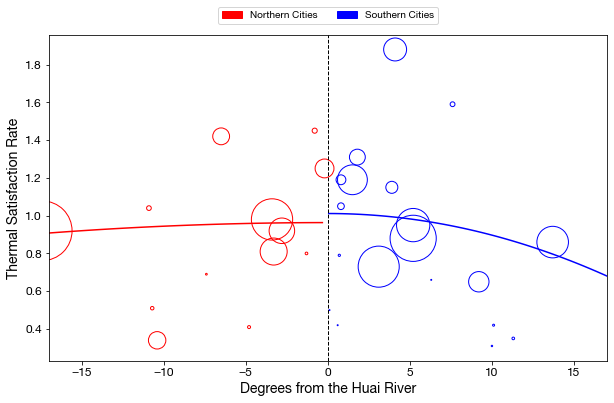

In [232]:

# Define a range of t_out_min values
t_out_min_values = np.linspace(df_rd_out['t_out_min'].min(), df_rd_out['t_out_min'].max(), 100)
t_out_min2_values = t_out_min_values ** 2

# Prepare a DataFrame for predictions
predict_df = pd.DataFrame({
    't_out_min': t_out_min_values,
    't_out_min2': t_out_min2_values,
    'threshold_out': (t_out_min_values >= 0).astype(int)  # 1 if t_out_min >= 0, else 0
})

# Generate predictions using the model
predict_df['predictions'] = model.predict(predict_df)

# Plot the data and the model's fitted values
plt.figure(figsize=(10, 6))

# Scatter plot for points below and above the threshold_out
df_below = df_rd_out[df_rd_out['t_out_min'] < 0]
df_above = df_rd_out[df_rd_out['t_out_min'] >= 0]
plt.scatter(df_below['t_out_min'], df_below['clo'], s=df_below['records'], facecolors='none', edgecolors='red', label='South')
plt.scatter(df_above['t_out_min'], df_above['clo'], s=df_above['records'], facecolors='none', edgecolors='blue', label='North')

# Plot the fitted values from the prediction DataFrame
plt.plot(predict_df['t_out_min'][predict_df['threshold_out'] == 0], predict_df['predictions'][predict_df['threshold_out'] == 0], color='red')
plt.plot(predict_df['t_out_min'][predict_df['threshold_out'] == 1], predict_df['predictions'][predict_df['threshold_out'] == 1], color='blue')

# Add a vertical dashed line at the threshold_out
plt.axvline(x=0, color='k', linestyle="--", linewidth=1)

# Label and style the plot
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-17, 17)
plt.xlabel('Degrees from the Huai River', fontsize=14)
plt.ylabel('Thermal Satisfaction Rate', fontsize=14)

# Add custom legend
blue_patch = mpatches.Patch(color='blue', label='Southern Cities')
red_patch = mpatches.Patch(color='red', label='Northern Cities')
plt.legend(handles=[red_patch, blue_patch], loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.show()


## RD concept graph

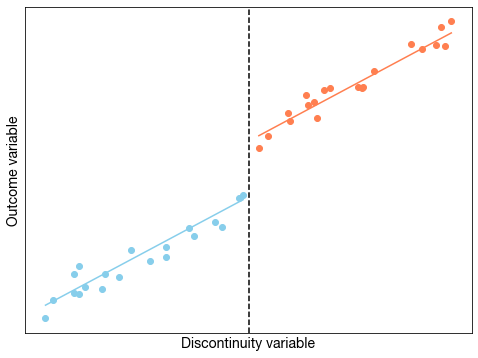

In [424]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data
np.random.seed(42)
x_control = np.random.uniform(-10, 0, 20)
y_control = 2 * x_control + 20 + np.random.normal(0, 2, 20)
x_treatment = np.random.uniform(0, 10, 20)
y_treatment = 2 * x_treatment + 30 + np.random.normal(0, 2, 20)

# Plot settings
fig, ax = plt.subplots(figsize=(8, 6))

# Plot control group
ax.scatter(x_control, y_control, color='skyblue', label='Control')
ax.plot(np.sort(x_control), 2 * np.sort(x_control) + 20, color='skyblue')

# Plot treatment group
ax.scatter(x_treatment, y_treatment, color='coral', label='Treatment')
ax.plot(np.sort(x_treatment), 2 * np.sort(x_treatment) + 30, color='coral')

# Vertical line for assignment cutoff
ax.axvline(x=0, color='black', linestyle='--')

# Add labels and annotations
ax.set_xlabel("Discontinuity variable", fontsize=14)
ax.set_ylabel("Outcome variable", fontsize=14)
# remove numbers on the x and y axis
ax.set_xticks([])
ax.set_yticks([])

# ax.text(-5, 20, "Control group", color='skyblue', fontsize=14)
# ax.text(0.5, 25, "Treatment group", color='coral', fontsize=14)
# ax.annotate("Treatment effect", xy=(0, 17), xytext=(1, 22),
#             arrowprops=dict(arrowstyle="->", lw=1.5))

# Legend and plot limits
# ax.legend()
# ax.set_xlim(-12, 12)
# ax.set_ylim(0, 30)

plt.show()
